In [8]:
#!pip install tqdm
#from tqdm import tqdm

In [23]:
from pathlib import Path
import sys
# Agregar el path del directorio "code"
code_path = Path("../code").resolve()
if str(code_path) not in sys.path:
    sys.path.insert(0, str(code_path))


In [ ]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.dates as mdates
from datetime import timedelta
from utils import SingleTlmyManager, get_dataset_folder #load_channel, , get_channels_file
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
from datetime import timedelta


BUSQUEDA_EXHAUSTIVA = False
RAWDATA             = False


mission_name = 'ESA-Mission1'
channel_name = "channel_44"



def plot_residual_diagnostics(series, model='additive', period=None, lags=40):
    """
    Realiza la descomposición estacional de una serie de tiempo y grafica 4 diagnósticos de los residuos:
    - Histograma con KDE
    - QQ plot
    - Residuos en el tiempo
    - Autocorrelación (ACF)
    
    Parámetros:
    - series: pd.Series con índice datetime
    - model: 'additive' o 'multiplicative'
    - period: estacionalidad esperada (por ejemplo, 12 para datos mensuales)
    - lags: número de rezagos a mostrar en el ACF
    """
    result = seasonal_decompose(series, model=model, period=period)
    resid = result.resid.dropna()

    fig, axs = plt.subplots(2, 2, figsize=(10, 6))

    # 1. Histograma con KDE
    sns.histplot(resid, kde=True, ax=axs[0, 0], color='skyblue')
    axs[0, 0].set_title('Histograma de residuos')

    # 2. QQ plot
    sm.qqplot(resid, line='s', ax=axs[0, 1])
    axs[0, 1].set_title('QQ plot de residuos')

    # 3. Residuos en el tiempo
    axs[1, 0].plot(resid, color='gray')
    axs[1, 0].set_title('Residuos a lo largo del tiempo')

    # 4. ACF
    plot_acf(resid, ax=axs[1, 1], lags=lags)
    axs[1, 1].set_title('ACF de residuos')

    plt.tight_layout()
    plt.show()


In [26]:
def get_accuracy(df_subset):
    TP      = df_subset[(df_subset["isAnomaly"]==True) & (df_subset["anomalyScore"]>0.5)].shape[0] 
    TN      = df_subset[(df_subset["isAnomaly"]==False) & (df_subset["anomalyScore"]<=0.5)].shape[0]
    FP      = df_subset[(df_subset["isAnomaly"]==False) & (df_subset["anomalyScore"]>0.5)].shape[0]
    FN      = df_subset[(df_subset["isAnomaly"]==True) & (df_subset["anomalyScore"]<=0.5)].shape[0]
    #TOTAL   = df_subset[df_subset["isAnomaly"]== True].shape[0]
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    #print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}, TOTAL: {TOTAL}, Accuracy: {accuracy:.2f}")
    return accuracy

In [27]:
#Mas de un minuto
if RAWDATA:
    # Cargar el canal directamente desde el archivo
    tm = SingleTlmyManager(mission_name, channel_name, 
                        start_date=pd.to_datetime('2000-01-01', utc=True),
                        end_date=pd.to_datetime('2001-12-31', utc=True))
    df = tm.regularize_freq()
    tm.add_labels()
    ag = tm.get_anomaly_groups()
    start_time = ag.loc[ag.anomalyId=="id_151","start_index"].loc[0]+timedelta(minutes=15)
    end_time = ag.loc[ag.anomalyId=="id_151","end_index"].loc[0]-timedelta(minutes=60*3)
    df = tm.data
    df_subset = df.loc[start_time:end_time]
    df_subset.to_csv(f"{get_dataset_folder()}/{mission_name}/{channel_name}_subset.csv")
    print(f"Data subset saved to {get_dataset_folder()}{mission_name}/{channel_name}_subset.csv")
else:
    df_subset   = pd.read_csv(f"{get_dataset_folder()}{mission_name}/{channel_name}_subset.csv", index_col=0, parse_dates=True)
    start_time = df_subset.index.min()
    end_time = df_subset.index.max()


Data subset saved to ../../data/ESA-Mission1/channel_44_subset.csv


Por el tipo de algoritmo trabajamos con menos datos respecto a IForest.

Dos bloques de test, uno sin anomalías y otro con anomalías según ESA. Lo bloques de test no se manejan por porcentajes sino por fecha exacta para la evaluación. Miramos las fechas para la selección.

In [25]:
#train_percent = 0.9
#train_test_rec = df_subset.iloc[int(train_percent*len(df_subset))]

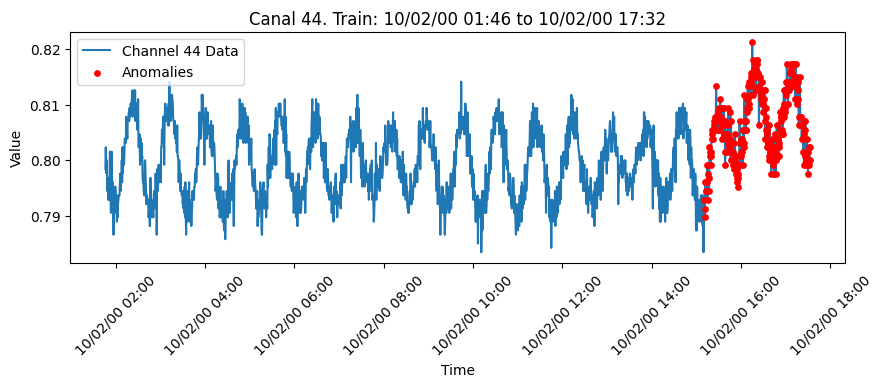

In [11]:
plt.figure(figsize=(10, 3))
plt.plot(df_subset.index, df_subset[channel_name], label='Channel 44 Data')
plt.scatter(df_subset.index[df_subset['isAnomaly']], df_subset[channel_name][df_subset['isAnomaly']], 
            color='red', 
            label='Anomalies', s=15, zorder=10)
plt.title(f'Canal 44. Train: {start_time.strftime("%d/%m/%y %H:%M")} to {end_time.strftime("%d/%m/%y %H:%M")}')
plt.xlabel('Time')  
plt.ylabel('Value')
plt.xticks(rotation=45)
d_format = mdates.DateFormatter("%d/%m/%y %H:%M")  # Día-Mes-Año
# Aplicar el formato al eje x
plt.gca().xaxis.set_major_formatter(d_format)

plt.legend()    
plt.show()

Establecemos periodos de test 01 y test 02

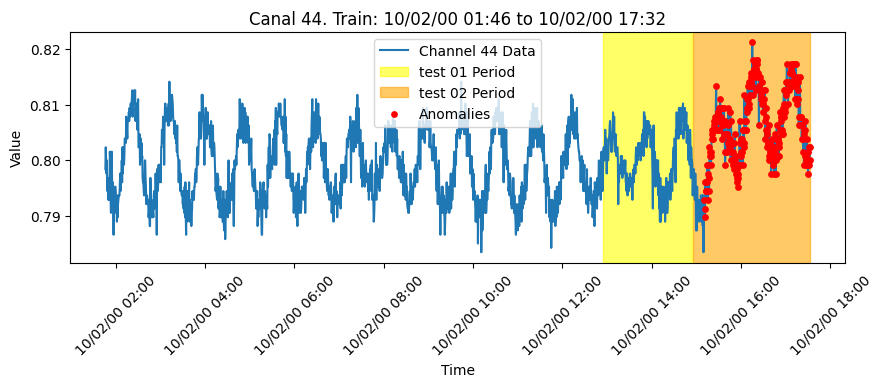

In [13]:
start_test_01_dt = pd.to_datetime('2000-02-10 12:55', utc=True)
end_test_01_dt = pd.to_datetime('2000-02-10 14:55', utc=True)
train = df_subset[df_subset.index < start_test_01_dt]
test_01 = df_subset[(df_subset.index >= start_test_01_dt) & (df_subset.index <= end_test_01_dt)]
test_02 = df_subset[df_subset.index > end_test_01_dt]
train_len = len(train)
total_len = len(df_subset)

plt.figure(figsize=(10, 3))
plt.plot(df_subset.index, df_subset[channel_name], label='Channel 44 Data')
plt.gca().axvspan(test_01.index[0], test_01.index[-1], color='yellow', alpha=0.6, label='test 01 Period')
plt.gca().axvspan(test_02.index[0], test_02.index[-1], color='orange', alpha=0.6, label='test 02 Period')

plt.scatter(df_subset.index[df_subset['isAnomaly']], df_subset[channel_name][df_subset['isAnomaly']], 
            color='red', 
            label='Anomalies', s=15, zorder=10)

plt.title(f'Canal 44. Train: {start_time.strftime("%d/%m/%y %H:%M")} to {end_time.strftime("%d/%m/%y %H:%M")}')
plt.xlabel('Time')  
plt.ylabel('Value')
plt.xticks(rotation=45)
d_format = mdates.DateFormatter("%d/%m/%y %H:%M")  # Día-Mes-Año
# Aplicar el formato al eje x
plt.gca().xaxis.set_major_formatter(d_format)

plt.legend()    
plt.show()


In [14]:
len(train), len(test_01), len(test_02), total_len, train_len+len(test_01)+len(test_02)

(1338, 240, 316, 1894, 1894)

¿Es estacionaria la serie?

In [15]:
serie = df_subset["channel_44"]
ADF_result = adfuller(serie)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -11.324423338417043
p-value: 1.1528525957486332e-20


El p-valor es muy bajo, rechazamos la hipotesis unitaria. Es una serie estacionaria.

Intentamos obtener la frecuencia dominante

In [16]:
serie_detrended = serie - np.mean(serie)
n = len(serie)
fft_vals = np.fft.fft(serie_detrended)
magnitude = np.abs(fft_vals)
freqs = np.fft.fftfreq(n, d=1)

half = slice(1, n // 2)
dominant_freq = freqs[half][np.argmax(magnitude[half])]
dominant_period = 1 / dominant_freq

print(f"Frecuencia dominante: {dominant_freq}")
print(f"Período dominante: {dominant_period}")

Frecuencia dominante: 0.01003167898627244
Período dominante: 99.6842105263158


Intentemos obtener la "season" de la serie...

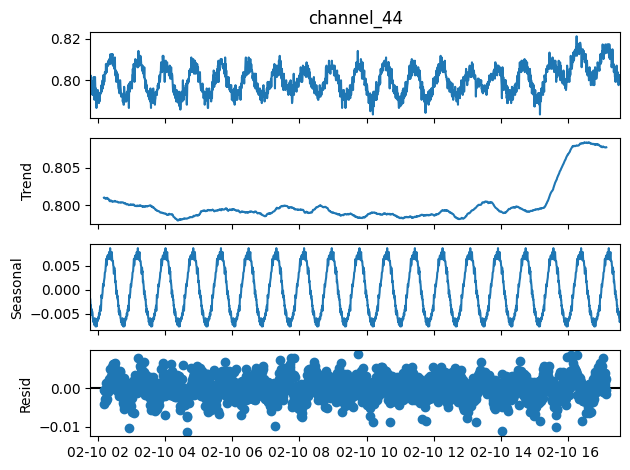

In [17]:
serie = df_subset["channel_44"]

result = seasonal_decompose(serie, model='additive', period=99)
result.plot()
plt.show()

¿Los residuos tienen una distribución normal y no correlacionada?

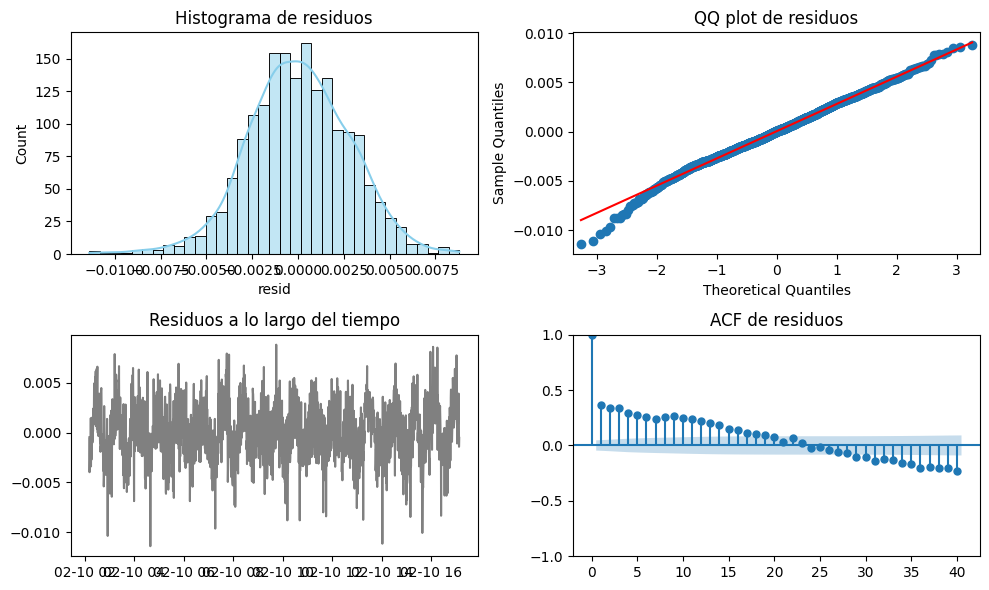

In [18]:
plot_residual_diagnostics(serie, model='additive', period=99, lags=40)

A simple vista hay autocorrelación en los residuos. Cuando el p-valor > 0.05 → no hay autocorrelación significativa y los residuos son ruido blanco el escenario es propicio para aplicar sarimax. Este escenario no parece ser el ideal, probablemente el principal problema es la estacionalidad no constante ni sincronizada con la frecuencia de muestreo.


In [19]:
ljungbox = acorr_ljungbox(result.resid.dropna(), auto_lag=True, return_df=True)
print(ljungbox)

           lb_stat      lb_pvalue
1       237.381490   1.464436e-53
2       444.504140   3.000215e-97
3       650.733955  1.009775e-140
4       807.978251  1.436135e-173
5       946.638649  2.140424e-202
...            ...            ...
1755  28664.279371   0.000000e+00
1756  28667.961545   0.000000e+00
1757  28672.901790   0.000000e+00
1758  28676.187782   0.000000e+00
1759  28678.747561   0.000000e+00

[1759 rows x 2 columns]


In [20]:
if BUSQUEDA_EXHAUSTIVA:
    ps = np.arange(0, 4, 1) 
    ds = np.arange(0, 1, 1) 
    qs = np.arange(0, 4, 1)

    Ps = np.arange(0, 2, 1)
    Ds = np.arange(0, 1, 1)
    Qs = np.arange(0, 2, 1)

    Ss = np.arange(98, 101, 1)
    g_search = product(ps, ds ,qs, Ps, Ds, Qs, Ss) 
    print(f"Total combinations: {len(list(product(ps, ds ,qs, Ps, Ds, Qs, Ss)))}")

    window = 5  # Tamaño de la ventana para las predicciones
    def optimize_ARIMA(serie, g_search):
        results = []
        for order in tqdm(g_search):
            try: 
                p, d, q, P, D, Q, S = order
                #enforce_invertibility=False
                model = SARIMAX(serie, order=(p,d,q), seasonal_order=(P, D, Q, S), simple_differencing=False).fit(disp=False)
                aic = model.aic
                results.append([(p, d, q, P, D, Q, S), aic])
            except:
                print(f"Error with order {order}, skipping...")
                continue

        result_df = pd.DataFrame(results, columns=['order', 'AIC'])
        result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
        return result_df
    df_opt_result = optimize_ARIMA(serie, g_search)
    df_opt_result.to_csv(f"df_opt_result_{mission_name}_{channel_name}.csv", index=False)  
    df_opt_result.iloc[0,0]
    p, d, q, P, D, Q, S = df_opt_result.iloc[0,0]
else:
    p, d, q, P, D, Q, S = (2, 0, 2, 1, 0, 0, 99)#df_opt_result.iloc[0,0]

#MLEResults.get_prediction(start=None, end=None, dynamic=False, information_set='predicted', signal_only=False, index=None, exog=None, extend_model=None, extend_kwargs=None, **kwargs)[source] (2, 0, 2, 1, 0, 0, 99)

In [21]:
model = SARIMAX(train["channel_44"], order=(p,d,q), seasonal_order=(P,D,Q,S))
res_test01 = model.fit()

d:\git\ESAHKTlmy\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
d:\git\ESAHKTlmy\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
d:\git\ESAHKTlmy\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\git\ESAHKTlmy\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
test  = test_01.copy()
y_pred = res_test01.predict(start=test.index[0], end=test.index[-1])
residuals = test["channel_44"]-y_pred

sigma = residuals.std()
z_scores = residuals / sigma
anomalies = z_scores[np.abs(z_scores) > 3]

n_steps = len(test["channel_44"])
forecast = res_test01.get_forecast(steps=n_steps)
# Obtener predicciones puntuales
predicted_mean = forecast.predicted_mean
# Obtener intervalo de confianza (por defecto al 95%)
conf_int = forecast.conf_int()
test["y_pred"] = False
test.loc[anomalies.index, "y_pred"] = True


df_FN = test.loc[(test.isAnomaly==True) & (test.y_pred==False), tm.channel_name]
df_FP = test.loc[(test.isAnomaly==False) & (test.y_pred==True), tm.channel_name]
df_TP = test.loc[(test.isAnomaly==True) & (test.y_pred==True), tm.channel_name]

plt.figure(figsize=(10, 5))
plt.plot(test["channel_44"], label='Serie original')
plt.scatter(df_FP.index, df_FP, color='orange', label='Falsos positivos', s=150, marker="v", zorder=8)
plt.scatter(df_FN.index, df_FN, color='red', label='Falsos negativos', s=40, zorder=9)
plt.scatter(df_TP.index, df_TP, color='green', label='Verdaderos positivos', marker='*', s=40, zorder=10)
plt.plot(y_pred, label='Pronóstico', color='violet', linewidth=2)

#plt.plot(predicted_mean, label='Pronóstico 2') es igual a y_pred
plt.fill_between(predicted_mean.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='IC 95%')
plt.legend()
plt.title("Pronóstico SARIMAX - Datos sin anomalías etiquetadas")
plt.show()

NameError: name 'tm' is not defined

Analicemos los residuos (deberían tener una distribución normal) y su relación con con 3-sigma

In [ ]:
def plot_residual_diagnostics(resid, y_pred=None):
    fig, axs = plt.subplots(3, 2, figsize=(8, 8))

    # 1. Residuos en el tiempo
    axs[0, 0].plot(resid)
    axs[0, 0].axhline(0, color='gray', linestyle='--')
    axs[0, 0].set_title("Residuos vs Tiempo")
    axs[0, 0].tick_params(axis='x', rotation=45)

    # 2. Histograma
    axs[0, 1].hist(resid, bins=30, edgecolor='black')
    axs[0, 1].set_title("Histograma de Residuos")

    # 3. Q-Q plot
    stats.probplot(resid, dist="norm", plot=axs[1, 0])
    axs[1, 0].set_title("Q-Q Plot")

    # 4. ACF
    plot_acf(resid, ax=axs[1, 1], lags=40)
    axs[1, 1].set_title("ACF de Residuos")

    # 5. Residuos vs Predicción (si hay)
    if y_pred is not None:
        axs[2, 0].scatter(y_pred, resid, alpha=0.5)
        axs[2, 0].axhline(0, color='gray', linestyle='--')
        axs[2, 0].set_title("Residuos vs Predicción")
        axs[2, 0].set_xlabel("Predicción")
        axs[2, 0].set_ylabel("Residuo")
    else:
        axs[2, 0].axis('off')
        axs[2, 0].text(0.3, 0.5, 'No se proporcionó y_pred', fontsize=12)

    # 6. Test de Ljung-Box
    ljung_box = acorr_ljungbox(resid, lags=[10], return_df=True)
    text = f"Ljung-Box p-valor (lag=10): {ljung_box['lb_pvalue'].iloc[0]:.3f}"
    axs[2, 1].axis('off')
    axs[2, 1].text(0.1, 0.5, text, fontsize=12)

    plt.tight_layout()
    plt.show()

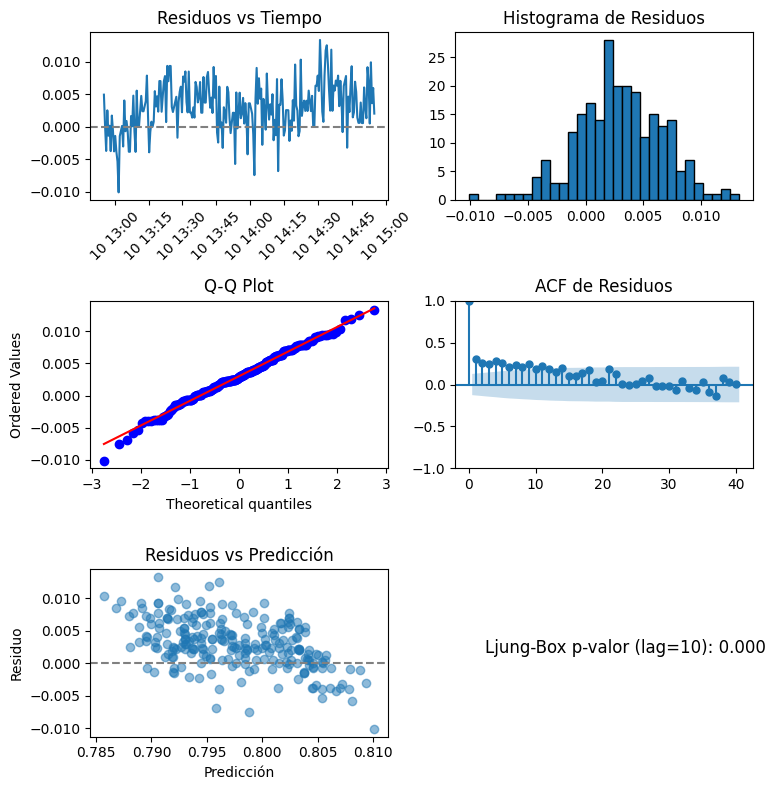

In [ ]:
plot_residual_diagnostics(resid=residuals, y_pred=y_pred)

In [ ]:
union_train = pd.concat([train, test_01])

In [ ]:
model = SARIMAX(union_train["channel_44"], order=(p,d,q), seasonal_order=(P,D,Q,S))
res_test02 = model.fit()


d:\git\Phd\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


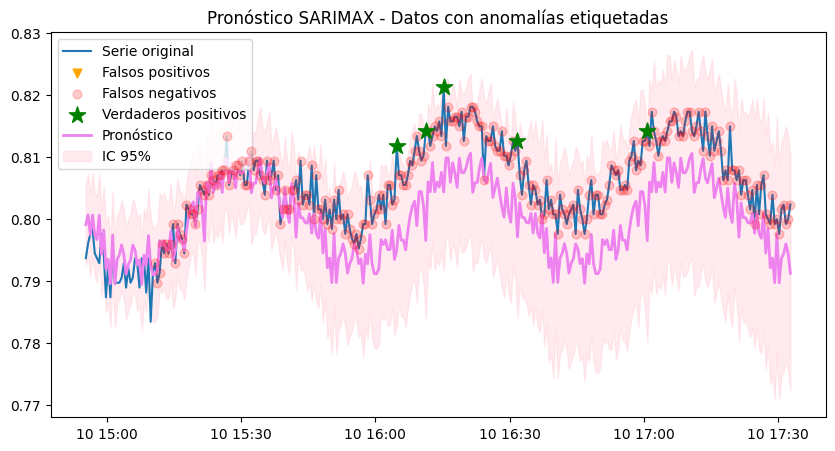

In [ ]:
test  = test_02.copy()
y_pred = res_test02.predict(start=test.index[0], end=test.index[-1])
residuals = test["channel_44"] -y_pred

sigma = residuals.std()
z_scores = residuals / sigma
anomalies = z_scores[np.abs(z_scores) > 3]

n_steps = len(test["channel_44"])
forecast = res_test02.get_forecast(steps=n_steps)
# Obtener predicciones puntuales
predicted_mean = forecast.predicted_mean
# Obtener intervalo de confianza (por defecto al 95%)
conf_int = forecast.conf_int()
test["y_pred"] = False
test.loc[anomalies.index, "y_pred"] = True


df_FN = test.loc[(test.isAnomaly==True) & (test.y_pred==False), tm.channel_name]
df_FP = test.loc[(test.isAnomaly==False) & (test.y_pred==True), tm.channel_name]
df_TP = test.loc[(test.isAnomaly==True) & (test.y_pred==True), tm.channel_name]

plt.figure(figsize=(10, 5))
plt.plot(test["channel_44"], label='Serie original')
plt.scatter(df_FP.index, df_FP, color='orange', label='Falsos positivos', s=40, marker="v", zorder=8)
plt.scatter(df_FN.index, df_FN, color='red', label='Falsos negativos', s=40, alpha=0.2, zorder=9)
plt.scatter(df_TP.index, df_TP, color='green', label='Verdaderos positivos', marker='*', s=150, zorder=10)
plt.plot(y_pred, label='Pronóstico', color='violet', linewidth=2)
#plt.plot(predicted_mean, label='Pronóstico 2') es igual a y_pred
plt.fill_between(predicted_mean.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='IC 95%')
plt.legend()
plt.title("Pronóstico SARIMAX - Datos con anomalías etiquetadas")
plt.show()